# 영화 평점 데이터

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [87]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, dtype={0: np.int32, 1: np.int32, 2: np.int32, 3: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path)
data.sort_values(['UserId', 'Time'], inplace=True)

### Data Preprocess

In [88]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- time은 Unix Time으로, 1970년 1월 1일부터 경과된 초 단위 시간이 기재돼있음

In [89]:
data['Time'] = pd.to_datetime(data['Time'], unit='s') # 달력 시간 형태로 변환

In [90]:
data.isna().sum() # 결측치 확인

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

In [91]:
data.duplicated().sum() # 중복 데이터 확인

0

In [92]:
# Data Cleansing
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [93]:
print(f"User 수: {data['UserId'].nunique()}")
print(f"Item 수: {data['ItemId'].nunique()}")

User 수: 6040
Item 수: 3706


In [94]:
user_length = data.groupby('UserId')['ItemId'].size() # 유저별 평가 데이터 수

In [95]:
user_length.describe() # 유저별 평가 데이터 수 분포

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: ItemId, dtype: float64

- 평가 데이터 수 평균: 165
- 평가 데이터 수 중앙값: 96
- 데이터 수 최솟값: 20
- 데이터 수 최댓값: 2314

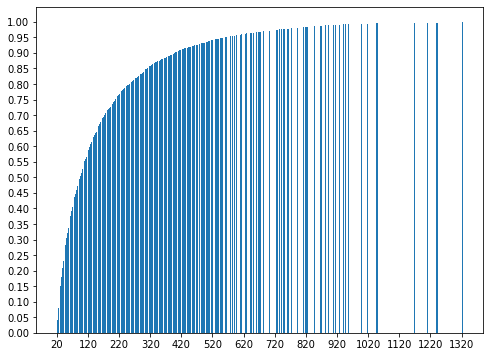

In [96]:
# 분포 누적합 
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize=(8, 6))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999)
plt.xticks(np.arange(length_percent_cumsum_999.index.min(), length_percent_cumsum_999.index.max(), 100))
plt.yticks(np.arange(0, 1.01, 0.05))
plt.show()

In [97]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(f'최초 날짜: {oldest}')
print(f'최종 날짜: {latest}')

최초 날짜: 2000-04-25 23:05:32
최종 날짜: 2003-02-28 17:49:50


- 약 3년 간의 데이터 존재
- 전체 데이터 수가 100만개 정도 되는데, 실습 데이터 양보다 적으므로 일단 모두 사용

In [98]:
data.groupby('ItemId').size().describe() # 영화별 평가된 횟수 통계치 확인

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
dtype: float64

- Data Cleansing의 경우, user_length에서 봤던 것처럼 평가 영화 수의 최솟값이 20이므로 제거할만한 user는 아직 확인 불가

### Data Split

In [99]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [100]:
def split_by_date(data: pd.DataFrame, n_days=int):
    final_time = data['Time'].max()
    cutoff_time = final_time-dt.timedelta(n_days)
    
    train = data.loc[data['Time']<cutoff_time]
    test = data.loc[(data['Time']>=cutoff_time) & (data['ItemId'].isin(train['ItemId']))]
    
    return train, test

In [101]:
# 2주 기준으로 분리 (실습처럼 1일 단위로 분리 시 검증/테스트 데이터 부족)
tr, test = split_by_date(data, n_days=14)
tr, val = split_by_date(tr, n_days=14)

In [102]:
print(f'tr: {len(tr):,}\nval: {len(val):,}\ntest: {len(test):,}')

tr: 998,710
val: 902
test: 597


In [103]:
# 정보 확인
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Status Info\n'
          f"\t Events: {len(data)}\n"
          f"\t Sessions: {data['UserId'].nunique()}\n"
          f"\t Items: {data['ItemId'].nunique()}\n"
          f"\t First Time: {data['Time'].min()}\n"
          f"\t Last Time: {data['Time'].max()}\n")

In [104]:
# cleansing
tr = cleanse_recursive(tr, shortest=2, least_click=5)
val = cleanse_recursive(val, shortest=2, least_click=1)
test = cleanse_recursive(test, shortest=2, least_click=1)

In [105]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Status Info
	 Events: 998112
	 Sessions: 6040
	 Items: 3416
	 First Time: 2000-04-25 23:05:32
	 Last Time: 2003-01-31 12:16:30

* valid Set Status Info
	 Events: 883
	 Sessions: 39
	 Items: 692
	 First Time: 2003-01-31 17:23:06
	 Last Time: 2003-02-14 02:02:32

* test Set Status Info
	 Events: 575
	 Sessions: 44
	 Items: 489
	 First Time: 2003-02-15 00:15:09
	 Last Time: 2003-02-28 17:49:50



In [106]:
id2idx = {item_id: index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1)) # tr에 없는 아이템은 -1 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

### Data Pipeline

In [107]:
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())
        
    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [108]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [109]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 997648, 997771, 998112], dtype=int32)

In [110]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [111]:
start = tr_dataset.click_offsets[tr_dataset.session_idx[[[0, 1, 2, 3]]]]
end = tr_dataset.click_offsets[tr_dataset.session_idx[[0, 1, 2, 3]]+1]

In [112]:
start

array([  0,  53, 182, 233], dtype=int32)

In [113]:
end

array([ 53, 182, 233, 254], dtype=int32)

In [114]:
(end - start).min() -1

20

In [115]:
inp = tr_dataset.df['item_idx'].values[start + 20]
inp

array([ 20,  71, 185,  88])

In [116]:
target = tr_dataset.df['item_idx'].values[start + 20 + 1]
target

array([ 21,  72, 186,  56])

In [117]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""


    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        
## 이부분에 batch_size 를 마지막에 남은 부분으 처리할수있게 코드 작성
#         self.batch_size = batch_size
        self.batch_size = min(batch_size, len(dataset.session_idx))  # 이 줄 추가

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [118]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [119]:
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


In [120]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [121]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [122]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [123]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## 배치사이즈를 너무 크게두면 밑에 평가 부분에서 nan이 나옵니다    
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)

In [124]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [125]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    tf.config.run_functions_eagerly(True)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                                     # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()

    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1) 
        # 
        if input_ohe.shape[0] < args.batch_size:
            pad_len = args.batch_size - input_ohe.shape[0]
            padding = np.zeros((pad_len, 1, args.num_items))
            input_ohe = np.concatenate([input_ohe, padding], axis=0)

        pred = model.predict(input_ohe, batch_size=args.batch_size)


        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])
    
    
    print(recall_list)
    print(mrr_list)
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [126]:
train_model(model, args)

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.25it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.051282
	 - MRR@20    epoch 1: 0.014530



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.076923
	 - MRR@20    epoch 2: 0.013442



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.75it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1111111111111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.076923
	 - MRR@20    epoch 3: 0.022080



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.51it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 4: 0.076923
	 - MRR@20    epoch 4: 0.032509



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.69it/s]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 5: 0.076923
	 - MRR@20    epoch 5: 0.019231



In [127]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05555555555555555, 0, 0, 0.25, 0, 0, 0, 0, 0, 0]
	 - Recall@20: 0.068182
	 - MRR@20: 0.012626



### Base
- args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)  
- validation: 	 
    - Recall@20 epoch 3: 0.051282
    - MRR@20    epoch 3: 0.005769
- test:
    - Recall@20: 0.068182
    - MRR@20: 0.012243

### drop_rate 변경 (0.1 -> 0.2)
- args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=3, k=20)
- validation: 	 
    - Recall@20 epoch 3: 0.051282
    - MRR@20    epoch 3: 0.013675
- test:
    - Recall@20: 0.090909
    - MRR@20: 0.007000
     
=> test의 Recall은 향상됐으나 MRR은 감소  
=> 큰 성능 차이가 없는 것으로 보아 과적합 상태는 아닌 것으로 보임

### lr 변경 (0.001 -> 0.005)
- args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.005, epochs=3, k=20)
- validation: 	 
    - Recall@20 epoch 3: 0.102564
    - MRR@20    epoch 3: 0.011823
- test:
    - Recall@20: 0.045455
    - MRR@20: 0.002936
    
=> test의 Recall과 MRR 모두 감소  
=> 수렴하지 못하는 것으로 보이며 다시 0.001로 원복

### epochs 변경 (3 -> 5)
- args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)
- validation: 	 
    - Recall@20 epoch 5: 0.076923
    - MRR@20    epoch 5: 0.019231
- test:
    - Recall@20: 0.068182
    - MRR@20: 0.012626
    
=> test의 Recall은 조금 감소했으나 MRR은 증가